# active inference model of agency task
# complex version with changed context that's being inferred by agent

### prerequisites

In [27]:
# !pip install inferactively-pymdp
import os
import sys
import pathlib
import numpy as np 
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pymdp

from pymdp import utils 
from pymdp import maths
from pymdp.maths import softmax
from pymdp.agent import Agent

### specifying the states and observations

In [28]:
""" Defining state factors """
context_names = ['positive_self', 'negative_self', 'positive_other', 'negative_other']
action_self_names = ['start_self', 'Press_self', 'noPress_self']
action_other_names = ['start_other', 'Press_other', 'noPress_other']

""" Defining number of state factors and states """
num_states = [len(context_self_names), len(action_self_names), len(action_other_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_context_names = ['equal_distribution']
choice_action_self_names = ['start_self', 'Action_self', 'noAction_self']
choice_action_other_names = ['equal_distribution']

""" Defining number of control states """
num_controls = [len(choice_context_self_names), len(choice_context_other_names), len(choice_action_self_names), len(choice_action_other_names)]

""" Defining observational modalities """
obs_outcome_names = ['outcome_start','outcome_present', 'outcome_absent']
obs_choice_self_names = ['start_self', 'Press_self', 'noPress_self']
obs_choice_other_names = ['start_other', 'Press_other', 'noPress_other']

""" Defining number of observational modalities and observations """
num_obs = [len(obs_outcome_names), len(obs_choice_self_names), len(obs_choice_other_names)]
num_modalities = len(num_obs)

In [29]:
def create_A(p_outcome):
    
    A = utils.initialize_empty_A(num_obs, num_states)
    
    '''likelihood matrix for outcome modality'''
    
    A_outcome = np.zeros( (len(obs_outcome_names), len(context_self_names), len(action_self_names), len(action_other_names)) )
    
    # P(outcome_start|start_self, start_other)
    A_outcome[0,:,0,0] = 1.0
    
    # P(outcome_start|start_self, Press_other)
    A_outcome[0,:,0,1] = 1.0
    
    # P(outcome_start|start_self, noPress_other)
    A_outcome[0,:,0,2] = 1.0
    
    # P(outcome_start|Press_self, start_other)
    A_outcome[0,:,1,0] = 1.0
    
    # P(outcome_start|noPress_self, start_other)
    A_outcome[0,:,2,0] = 1.0
    
    # P(outcome|Press_self, Press_other)
    A_outcome[:,:,1,1] = [[0.0, 0.0, 0.0, 0.0], 
                          [p_outcome, 1.0 - p_outcome, p_outcome, 1.0 - p_outcome],
                          [1.0 - p_outcome, p_outcome, 1.0 - p_outcome, p_outcome]]
    
    # P(outcome|Press_self, noPress_other)
    A_outcome[:,:,1,2] = [[0.0, 0.0, 0.0, 0.0], 
                          [p_outcome, 1.0 - p_outcome, 1.0 - p_outcome, p_outcome],
                          [1.0 - p_outcome, p_outcome, p_outcome, 1.0 - p_outcome]]
    
    # P(outcome|noPress_self, Press_other)
    A_outcome[:,:,2,1] = [[0.0, 0.0, 0.0, 0.0], 
                          [1.0 - p_outcome, p_outcome, p_outcome, 1.0 - p_outcome],
                          [p_outcome, 1.0 - p_outcome, 1.0 - p_outcome, p_outcome]]
    
    # P(outcome|noPress_self, noPress_other)
    A_outcome[:,:,2,2] = [[0.0, 0.0, 0.0, 0.0], 
                          [1.0 - p_outcome, p_outcome, 1.0 - p_outcome, p_outcome],
                          [p_outcome, 1.0 - p_outcome, p_outcome, 1.0 - p_outcome]]
    
    
    '''likelihood matrix for proprioception modality'''        
    A_choice_self = np.zeros((len(obs_choice_self_names), len(context_names), len(action_self_names), len(action_other_names)))
    
    # P(start_self|start_self, any_action_other)
    A_choice_self[0,:,0,:] = 1.0
    
#     # P(start_self|start_self, Press_other)
#     A_choice_self[0,:,0,1] = 1.0
    
#     # P(start_self|start_self, noPress_other)
#     A_choice_self[0,:,0,2] = 1.0
    
    # P(Press_self|Press_self, any_action_other)
    A_choice_self[1,:,1,:] = 1.0
    
#     # P(Press_self|Press_self, Press_other)
#     A_choice_self[1,:,1,1] = 1.0
    
#     # P(Press_self|Press_self, noPress_other)
#     A_choice_self[1,:,1,2] = 1.0
    
    # P(noPress_self|noPress_self, any_action_other)
    A_choice_self[2,:,2,:] = 1.0
    
#     # P(noPress_self|noPress_self, Press_other)
#     A_choice_self[2,:,2,1] = 1.0
    
#     # P(noPress_self|noPress_self, noPress_other)
#     A_choice_self[2,:,2,2] = 1.0
    
    
    '''likelihood matrix for other agent's proprioception modality'''        
    A_choice_other = np.zeros((len(obs_choice_other_names), len(context_names), len(action_self_names), len(action_other_names)))
    
    # P(start_other|start_self, start_other)
    A_choice_other[0,:,:,0] = 1.0
    
    # P(Press_other|start_self, Press_other)
    A_choice_other[1,:,:,1] = 1.0
    
    # P(noPress_other|start_self, noPress_other)
    A_choice_other[2,:,:,2] = 1.0
    
#     # P(observation|Press_self, start_other)
#     A_choice_other[0,:,1,0] = 1.0
    
#     # P(observation|Press_self, Press_other)
#     A_choice_other[1,:,1,1] = 1.0
    
#     # P(observation|Press_self, noPress_other)
#     A_choice_other[2,:,1,2] = 1.0
    
#     # P(observation|noPress_self, start_other)
#     A_choice_other[0,:,2,0] = 1.0
    
#     # P(observation|noPress_self, Press_other)
#     A_choice_other[1,:,2,1] = 1.0
    
#     # P(observation|noPress_self, noPress_other)
#     A_choice_other[2,:,2,2] = 1.0
        
    A[0], A[1], A[2] = A_outcome, A_choice_self, A_choice_other
    
    return A

# A = create_A(p_outcome = 1.0)
# utils.plot_likelihood(A[0][:,:,0,0], title = "P(outcome_start|start_self, start_other)")
# utils.plot_likelihood(A[0][:,:,1,2], title = "P(outcome|Press_self, noPress_other)")
# utils.plot_likelihood(A[2][:,:,0,1], title = "P(other_action|noPress_self, noPress_other)")


In [30]:
def create_B():
    # `p_change`: probability of the context changing
    B = utils.initialize_empty_B(num_states, num_states)
    
    B_context = np.zeros( (len(context_names), len(context_names), len(choice_context_names)) )
    B_context[:,:,0] = np.array(1.0/float(num_states[0]))
    
    B_choice_self = np.zeros( (len(action_self_names), len(action_self_names), len(choice_action_self_names)) )
    
    for choice_i in range(len(action_self_names)):
        B_choice_self[choice_i, :, choice_i] = 1.0
    
    B_choice_other = np.zeros( (len(action_other_names), len(action_other_names), len(choice_action_other_names)) )
    
    for choice_i in range(len(action_other_names)):
        B_choice_other[:,:,0] = np.array(1.0/float(num_states[2]))
        
    B[0], B[1], B[2] = B_context, B_choice_self, B_choice_other
    
    return B

# B = create_B(p_change=0.0)
# print(B[0][:,:,0])

In [31]:
def create_C(outcomepref, actionpref, noactionpref):
    
    # define reward and punishment values mapping onto outcome_present and outcome_absent preferences
    
    C = utils.obj_array_zeros(num_obs)
    C[0] = np.array([0.0, outcomepref, 0.0])
    C[1] = np.array([0.0, actionpref, noactionpref])
    C[2] = np.array([0.0, 0.0, 0.0])
    
    return C

# C = create_C(reward = 1.0, pun = 0.0)
# utils.plot_beliefs(softmax(C[0]), title = "Prior preferences for outcome_present and outcome_absent")

In [32]:
def create_D():
    
    D = utils.obj_array(num_factors)
    
    D_context = np.ones(num_states[0])/float(num_states[0])
    
    D_choice_self = np.zeros(len(action_self_names)) 
    D_choice_self[action_self_names.index("start_self")] = 1.0
    
    D_choice_other = np.zeros(len(action_other_names)) 
    D_choice_other[action_other_names.index("start_other")] = 1.0

    D[0], D[1], D[2] = D_context, D_choice_self, D_choice_other
    
    return D

# D = create_D(p_context=1/float(num_states[0]))
# utils.plot_beliefs(softmax(D[1]), title = "Prior beliefs about probability of the contexts")

In [55]:
expcondition_names = ['self_positive', 'self_negative', 'other_positive', 'other_negative', 'zero']
num_expcondition = len(expcondition_names)
print(num_states[0])
print(np.ones(num_states[0])/float(num_states[0]))
print(float(num_expcondition))
print(np.ones(int(num_expcondition)/int(num_expcondition)))

4
[0.25 0.25 0.25 0.25]
5.0


TypeError: 'float' object cannot be interpreted as an integer

In [33]:
class AgencyTask(object):
    
    def __init__(self, expcondition = None, p_action_other = 0.5, p_outcome = 1.0):
        
        self.expcondition_names = ['self_positive', 'self_negative', 'other_positive', 'other_negative', 'zero']
        num_expcondition = len(self.expcondition_names)
        if expcondition == None:
            self.expcondition = self.expcondition_names[utils.sample(np.ones(num_expcondition/float(num_expcondition)))] # randomly sample which context is selected
        else:
            self.expcondition = expcondition
            
        self.p_outcome = p_outcome
        self.p_action_other = p_action_other
        
        self.obs_outcome_names = ['outcome_start', 'outcome_present', 'outcome_absent']
        
        
    def step(self, action):
        
        self.action_other_names = ['start_other', 'Action_other', 'noAction_other']
        self.action_other = self.action_other_names[utils.sample(np.array([0.0, self.p_action_other, 1.0-self.p_action_other]))]
        
        if action == "start_self" and self.action_other == "start_other":
            observed_choice_self = "start_self"
            observed_choice_other = "start_other"
            observed_outcome = "outcome_start"
                
        elif action == "Action_self" and self.action_other == "Action_other":
            observed_choice_self = "Press_self"
            observed_choice_other = "Press_other"
            
            if self.expcondition == "self_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "self_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "zero":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]
                
        elif action == "Action_self" and self.action_other == "noAction_other":
            observed_choice_self = "Press_self"
            observed_choice_other = "noPress_other"
            
            if self.expcondition == "self_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "self_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "zero":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]
                
        elif action == "noAction_self" and self.action_other == "Action_other":
            observed_choice_self = "noPress_self"
            observed_choice_other = "Press_other"
            
            if self.expcondition == "self_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "self_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "zero":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]
                
        elif action == "noAction_self" and self.action_other == "noAction_other":
            observed_choice_self = "noPress_self"
            observed_choice_other = "noPress_other"
            
            if self.expcondition == "self_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "self_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_positive":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_negative":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "zero":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]

        obs = [observed_outcome, observed_choice_self, observed_choice_other]

        return obs

In [39]:
def run_active_inference_loop(my_agent, my_env, T, verbose):
    
    """ Initialize the first observation """
    obs_label = ["outcome_start", "start_self", "start_other"]  
    obs = [obs_outcome_names.index(obs_label[0]), obs_choice_self_names.index(obs_label[1]), obs_choice_other_names.index(obs_label[2])]
    
    first_choice = obs_choice_self_names.index(obs_label[1])
    choice_hist = np.zeros((3,T+1))
    choice_hist[first_choice,0] = 1.0
    
    belief_hist = np.zeros((5, T))
    belief_action_self_hist = np.zeros((3, T))
    belief_action_other_hist = np.zeros((3, T))
    
    context_hist = np.zeros(T)
    outcome_hist = np.zeros((3,T))
    
    for t in range(T):
        context_hist[t] = env.context_names.index(env.context)
        qs = my_agent.infer_states(obs)
        
        belief_hist[:,t] = qs[0]
        belief_action_self_hist[:,t] = qs[1]
        belief_action_other_hist[:,t] = qs[2]
        
        outcome_hist[obs[0],t] = 1.0
        
        if verbose:
             utils.plot_beliefs(qs[0], title = f"Beliefs about the context at time {t}")
#             utils.plot_beliefs(qs[1], title = f"Beliefs about the action_self at time {t}")
#             utils.plot_beliefs(qs[2], title = f"Beliefs about the action_other at time {t}")
            
        q_pi, efe = my_agent.infer_policies()
        chosen_action_id = my_agent.sample_action()
        
        movement_id = int(chosen_action_id[1])
        choice_hist[movement_id,t+1]= 1.0
        
        choice_action = choice_action_self_names[movement_id]
        
        obs_label = my_env.step(choice_action)
        
        obs = [obs_outcome_names.index(obs_label[0]), obs_choice_self_names.index(obs_label[1]), obs_choice_other_names.index(obs_label[2])]
        
        if verbose:
            print(f'Action at time {t}: {choice_action}')
            print(f'Outcome at time {t}: {obs_label[0]}')
            print(f'Obs_action_self at time {t}: {obs_label[1]}')
            print(f'Obs_action_other at time {t}: {obs_label[2]}')

    return choice_hist, belief_hist, context_hist,  belief_action_other_hist, outcome_hist

In [40]:
def plot_some_choices_beliefs(choice_hist, belief_hist, context_hist, pad_val=5.0):
    T = choice_hist.shape[1]
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15,13))
    
    axes[0].imshow(choice_hist[:,:-1], cmap = 'gray') 
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(3))
    axes[0].set_yticklabels(labels = choice_action_self_names)
    axes[0].set_title('Actions produced by Self over time')
    
    axes[1].imshow(belief_hist, cmap = 'gray')
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(5))
    axes[1].set_yticklabels(labels = context_names)
    axes[1].set_title('Beliefs over time')
    axes[1].scatter(np.arange(T-1), context_hist, c = 'r', s = 50)
    
    fig.tight_layout(pad=pad_val)
    plt.show()

In [41]:
def plot_all_choices_beliefs(choice_hist, belief_hist, context_hist, belief_action_other_hist, outcome_hist, pad_val=1.0):
    T = choice_hist.shape[1]
    fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (15,20))
    
    axes[0].imshow(belief_hist, cmap = 'gray')
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(5))
    axes[0].set_yticklabels(labels = context_names)
    axes[0].set_title('Beliefs over time')
    axes[0].scatter(np.arange(T-1), context_hist, c = 'r', s = 50)
        
    axes[1].imshow(choice_hist[:,:-1], cmap = 'gray') 
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(3))
    axes[1].set_yticklabels(labels = action_self_names)
    axes[1].set_title('Actions produced by Self over time')
    
    axes[2].imshow(belief_action_other_hist[:,:-1], cmap = 'gray') 
    axes[2].set_xlabel('Timesteps')
    axes[2].set_yticks(ticks = range(3))
    axes[2].set_yticklabels(labels = action_other_names)
    axes[2].set_title('Actions produced by Other over time')

    axes[3].imshow(outcome_hist[:,:-1], cmap = 'gray') 
    axes[3].set_xlabel('Timesteps')
    axes[3].set_yticks(ticks = range(3))
    axes[3].set_yticklabels(labels = obs_outcome_names)
    axes[3].set_title('Outcomes observed over time')

    fig.tight_layout(pad=pad_val)
    plt.show()

In [42]:
p_outcome_env = 1.0
p_action_other_env = 0.5

env = AgencyTask(p_action_other = p_action_other_env, p_outcome = p_outcome_env)

T = 15

A = create_A(p_outcome = 1.0)
B = create_B(p_change = 0.0)
C = create_C(outcomepref = 1.0, actionpref = -0.5, noactionpref = 0.0)
D = create_D()
my_agent = Agent(A=A, B=B, C=C, D=D)

choice_hist, belief_hist, context_hist, belief_action_other_hist, outcome_hist = run_active_inference_loop(my_agent, env, T = T, verbose = False)

TypeError: 'float' object cannot be interpreted as an integer

In [38]:
plot_some_choices_beliefs(choice_hist, belief_hist, context_hist)

NameError: name 'choice_hist' is not defined

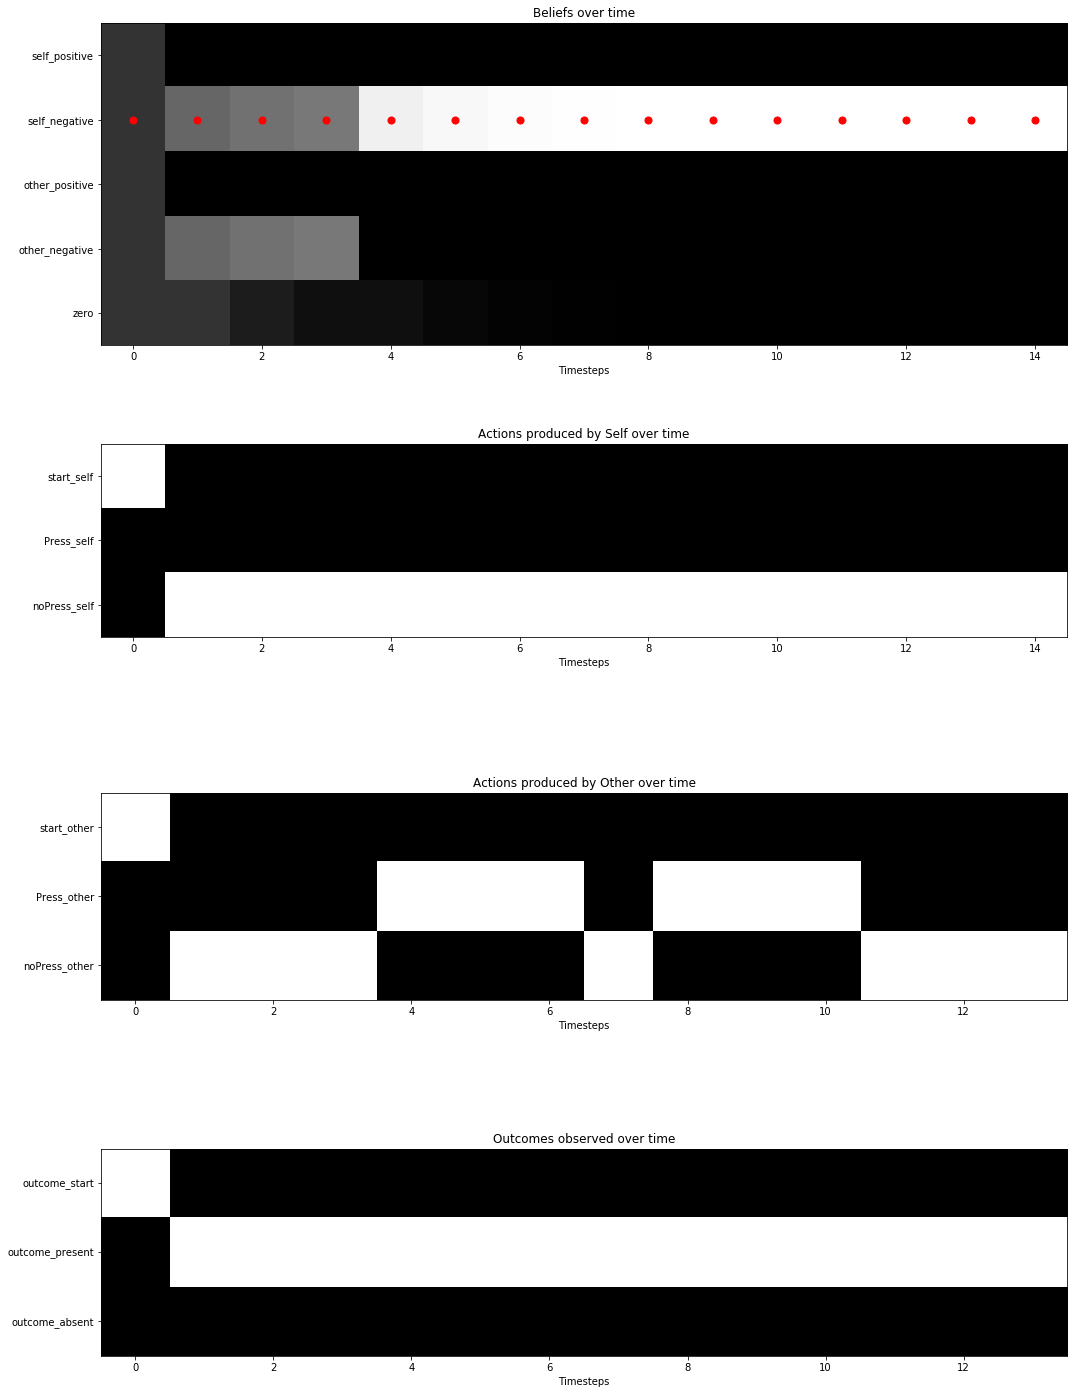

In [45]:
plot_all_choices_beliefs(choice_hist, belief_hist, context_hist, belief_action_other_hist, outcome_hist)